# Loan Risk Analysis
by Faykel Nicandro Hattu

### Outline

* Business Problem
* Data Understanding
* Data Cleaning and Feature Engineering
* Data Analysis
* Data Preparation
* Modeling
* Conclusion

## Business Problem

### Background

Money lending occurs in almost every business in the world. People with much money will lend it to those who need it. They do not lend their money for free; they charge interest. The larger amount and the longer term will result in a higher interest rate. This could occur in a bank, from company to company, or even from person to person.

In reality, this lending process is not as simple as it appears. There are so many things to consider to make sure that the borrower can and will pay back the loaned money and the interest.

### Problem Statement

A lending company client wants to lend their money to borrowers in a riskless condition for the company. As a Data Scientist, they want us to predict which customer is in the good category based on their credit risk to get the loaned money.

### Goals

As the problem given, this analysis' goal are to be able to predict which customer are Good Borrower and which are Bad Borrower. Good Borrower is someone who repays all the loaned money on time, and the Bad Borrower is someone who repays a loan late or does not repay it at all.

By knowing this, the company can avoid borrower with higher risk (late repay or not repay).

### Analytic Approach

Classification Machine learning will be used to determine which borrowers are less risky and more likely to repay the loan by using ROC/AUC performance.

## Data Understanding

### Library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import missingno as msno

# Model and Preparation
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score

# Information Value
import scipy.stats as stats
from pandas.core.dtypes.common import is_numeric_dtype

# Save Model
import pickle

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

### Function

In [3]:
title_font = dict(size=15, weight="bold")

def countplot(df, y, title, **sns_kwargs):
    value_counts = df[y].value_counts()
    percentage = value_counts / value_counts.sum()
    percentage = percentage.apply("{:.2%}".format)
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.countplot(data=df, y=y, order=value_counts.index, **sns_kwargs)
    plt.ylabel("")
    plt.show()
    print(percentage)

def histplot(df, x, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.histplot(data=df, x=x, kde=True, **sns_kwargs)
    plt.ylabel("")
    plt.show()

def boxplot(df, x, y, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.boxplot(data=df, x=x, y=y, **sns_kwargs)
    plt.ylabel("")
    plt.show()

In [4]:
def missingmatrix (data):
    msno.matrix(data)
    gray_patch = mpatches.Patch(color='gray', label='Ada Data')
    white_patch = mpatches.Patch(color='white', label='Missing Value')
    plt.legend(handles=[gray_patch, white_patch])
    plt.title('Matrix Plot Missing Value', fontsize=20)
    plt.show()

# Fungsi Matrix missingness berdasarkan value
def msnosort(data, value):
    msno.matrix(data.sort_values(by=[value], axis=0, ascending=True))
    gray_patch = mpatches.Patch(color='gray', label='Ada Data')
    white_patch = mpatches.Patch(color='white', label='Missing Value') 
    plt.legend(handles=[gray_patch, white_patch])
    plt.title(f'Matrix Plot Missing Value Berdasarkan {value}', fontsize=20)
    plt.show()

### Dataset

In [5]:
data = pd.read_csv("loan_data_2007_2014.csv")

In [6]:
data['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In this dataset, loan status is the only feature that can be used as the target. To determine the best result, we want a clear section that shows only finished cases. Therefore, we only use a few categories: `Fully Paid` as the recommendation for the good borrower and `Charged Off`, `Default`, `Does not meet the credit policy as recommendation. Status:Fully Paid` and `Does not meet the credit policy as recommendation. Status:Charged Off)` for the bad borrower. All the data excluding those 5 values will be removed because it's still not clear whether they are good or bad borrowers.

In [7]:
Good = ["Fully Paid"]
Bad = ["Charged Off", "Late (16-30 days)", "Late (31-120 days)", "Default", "Does not meet the credit policy. Status:Fully Paid", "Does not meet the credit policy. Status:Charged Off"]

df = data[data['loan_status'].isin(Good + Bad)]
df.shape

(238913, 75)

After removing other values, the good and bad values will be categorized as 0 (Good) and 1 (Bad).

In [8]:
def Target(status):
    if status == 'Fully Paid':
        return 0
    else:
        return 1
df['loan_status'] = df['loan_status'].apply(lambda status: Target(status))
df['loan_status'].value_counts()

0    184739
1     54174
Name: loan_status, dtype: int64

### Attribute information

In [9]:
df.shape

(238913, 75)

In [10]:
df.describe()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,238913.00000,2.389130e+05,2.389130e+05,238913.000000,238913.000000,238913.000000,238913.000000,238913.000000,2.389090e+05,238913.000000,238913.000000,238884.000000,238884.000000,105385.000000,28949.000000,238884.000000,238884.000000,2.389130e+05,238681.000000,238884.000000,238913.000000,238913.000000,238913.000000,238913.000000,238913.000000,238913.000000,238913.000000,238913.000000,238913.000000,238913.000000,238768.000000,42544.000000,238913.0,0.0,0.0,0.0,238884.000000,1.722900e+05,1.722900e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.722900e+05,0.0,0.0,0.0
mean,195611.35245,8.584147e+06,9.703611e+06,13486.214647,13440.797173,13312.662461,13.855453,416.935049,7.192866e+04,0.226752,16.439675,0.248300,0.906859,34.909408,75.252824,10.858325,0.134932,1.522316e+04,54.995834,24.812034,375.020566,374.891575,13382.976237,13251.594073,11083.394476,2132.077634,0.938372,166.565761,17.490169,5659.944597,0.005939,42.926335,1.0,NaN,NaN,NaN,0.002897,2.009637e+02,1.365678e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.910103e+04,NaN,NaN,NaN
std,133731.94613,9.288258e+06,1.007888e+07,8066.725464,8042.190169,8080.099456,4.380770,243.750417,5.510420e+04,0.418732,7.698582,0.735872,1.173756,21.839102,31.666770,4.827772,0.421437,1.919444e+04,24.671291,11.664663,2329.745202,2329.040248,9389.841702,9401.574493,8155.974905,2163.315265,6.331726,762.644734,118.808133,6847.082795,0.083821,21.489931,0.0,NaN,NaN,NaN,0.058517,2.211009e+04,1.501802e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.854495e+04,NaN,NaN,NaN
min,0.00000,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,83014.00000,1.382529e+06,1.616779e+06,7200.000000,7200.000000,7125.000000,10.990000,239.410000,4.500000e+04,0.000000,10.720000,0.000000,0.000000,16.000000,54.000000,7.000000,0.000000,5.913000e+03,37.300000,16.000000,0.000000,0.000000,6283.847416,6160.220000,4881.150000,746.020000,0.000000,0.000000,0.000000,417.750000,0.000000,26.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,2.795400e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.320000e+04,NaN,NaN,NaN
50%,183235.00000,5.524581e+06,6.479428e+06,12000.000000,12000.000000,11914.311470,13.670000,365.230000,6.145000e+04,0.000000,16.140000,0.000000,1.000000,32.000000,80.000000,10.000000,0.000000,1.098800e+04,56.700000,23.000000,0.000000,0.000000,11230.080000,11125.850000,9623.070000,1467.260000,0.000000,0.000000,0.000000,2923.690000,0.000000,42.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,7.923900e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.200000e+04,NaN,NaN,NaN
75%,296533.00000,1.248597e+07,1.445739e+07,18000.000000,18000.000000,18000.000000,16.590000,545.960000,8.600000e+04,0.000000,21.880000,0.000000,1.000000,51.000000,102.000000,13.000000,0.000000,1.906700e+04,74.500000,32.000000,0.000000,0.000000,18158.980000,18015.650000,15125.000000,2706.540000,0.000000,0.000000,0.000000,8808.520000,0.000000,60.000000,1.0,NaN,NaN,NaN,0.000000,0.0

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238913 entries, 0 to 466283
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   238913 non-null  int64  
 1   id                           238913 non-null  int64  
 2   member_id                    238913 non-null  int64  
 3   loan_amnt                    238913 non-null  int64  
 4   funded_amnt                  238913 non-null  int64  
 5   funded_amnt_inv              238913 non-null  float64
 6   term                         238913 non-null  object 
 7   int_rate                     238913 non-null  float64
 8   installment                  238913 non-null  float64
 9   grade                        238913 non-null  object 
 10  sub_grade                    238913 non-null  object 
 11  emp_title                    225435 non-null  object 
 12  emp_length                   229688 non-null  object 
 13 

- There are 17 columns with completely no data. Those columns will be removed.

### Categoric

In [12]:
kat1= []
for i in df.select_dtypes(include=object).columns:
    if df[i].nunique():
        kat1.append(i)
    else:
        continue

listItem = []
for col in df[kat1] :
    listItem.append([col, df[col].nunique(), df[col].unique()])

dfDesc = pd.DataFrame(columns=['dataFeatures','unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,unique,uniqueSample
0,term,2,"[ 36 months, 60 months]"
1,grade,7,"[B, C, A, E, F, D, G]"
2,sub_grade,35,"[B2, C4, C5, C1, A4, E1, F2, B5, C3, B1, D1, A1, B3, B4, C2, D2, A3, A5, D5, A2, E4, D3, D4, F3,..."
3,emp_title,129889,"[nan, Ryder, AIR RESOURCES BOARD, Veolia Transportaton, MKC Accounting , Starbucks, Southwest Ru..."
4,emp_length,11,"[10+ years, < 1 year, 3 years, 9 years, 4 years, 5 years, 1 year, 6 years, 2 years, 7 years, 8 y..."
5,home_ownership,6,"[RENT, OWN, MORTGAGE, OTHER, NONE, ANY]"
6,verification_status,3,"[Verified, Source Verified, Not Verified]"
7,issue_d,91,"[Dec-11, Nov-11, Oct-11, Sep-11, Aug-11, Jul-11, Jun-11, May-11, Apr-11, Mar-11, Feb-11, Jan-11,..."
8,pymnt_plan,2,"[n, y]"
9,url,238913,"[https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501, https://www.lendingclub.c..."


- Column `term` will be changed to numeric (36 months -> 36, 60 months -> 60)
- Column `emp_length` will be changed to numeric (2 years -> 2, etc)
- Customer grade already represented by column `grade`. Therefore, `sub_grade` will be deleted.
- Column `emp_title`, `url`, `desc`, `title`, `emp_title` and `title` has high cardinality. Columns will be deleted.
- Column `zip_code` are representing customer location. This value already represented by column `addr_state`. Therefore, `zip_code` will be deleted.
- Column `application_type` have only 1 value. Column will be deleted.
- Column `home_ownership` has unclear values. Further analysis will be performed on Feature Engineering section.

### Numeric

In [13]:
Num1= []
for i in df.select_dtypes(exclude=object).columns:
    if df[i].nunique():
        Num1.append(i)
    else:
        continue

listItem = []
for col in df[Num1] :
    listItem.append([col, df[col].nunique(), df[col].unique()])

dfDesc = pd.DataFrame(columns=['dataFeatures','unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,unique,uniqueSample
0,Unnamed: 0,238913,"[0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,..."
1,id,238913,"[1077501, 1077430, 1077175, 1076863, 1075269, 1072053, 1071795, 1071570, 1070078, 1069908, 10646..."
2,member_id,238913,"[1296599, 1314167, 1313524, 1277178, 1311441, 1288686, 1306957, 1306721, 1305201, 1305008, 12987..."
3,loan_amnt,1310,"[5000, 2500, 2400, 10000, 3000, 5600, 5375, 6500, 12000, 9000, 1000, 3600, 6000, 9200, 20250, 21..."
4,funded_amnt,1313,"[5000, 2500, 2400, 10000, 3000, 5600, 5375, 6500, 12000, 9000, 1000, 3600, 6000, 9200, 20250, 21..."
5,funded_amnt_inv,9560,"[4975.0, 2500.0, 2400.0, 10000.0, 5000.0, 3000.0, 5600.0, 5350.0, 6500.0, 12000.0, 9000.0, 1000...."
6,int_rate,505,"[10.65, 15.27, 15.96, 13.49, 7.9, 18.64, 21.28, 12.69, 14.65, 9.91, 16.29, 6.03, 11.71, 12.42, 1..."
7,installment,43848,"[162.87, 59.83, 84.33, 339.31, 156.46, 109.43, 152.39, 121.45, 153.45, 402.54, 305.38, 96.68, 32..."
8,annual_inc,18715,"[24000.0, 30000.0, 12252.0, 49200.0, 36000.0, 48000.0, 40000.0, 15000.0, 72000.0, 75000.0, 10000..."
9,loan_status,2,"[0, 1]"


- `Unnamed: 0`, `id` and `member_id` are unique columns. Those columns will be deleted.
- `policy_code` only have 1 value. Column will be deleted.

### Result of Data Understanding
- As target, only *Fully Paid*, *Charged Off*, *Default* and *Does not meet the credit policy* of `loan_status` values data are used. *Fully Paid* (the good category) changed to 1 and the others changed to 0.
- Column `term` will be changed to numeric (36 months -> 36, 60 months -> 60).
- Column `emp_length` will be changed to numeric (2 years -> 2, etc).
- Customer grade already represented by column `grade`. Therefore, `sub_grade` will be deleted.
- Column `zip_code` are representing customer location. This value already represented by column `addr_state`. Therefore, `zip_code` will be deleted.
- Column `emp_title`, `url`, `desc` and `title` has high cardinality. Columns will be deleted.
- Column `Unnamed: 0`, `id` and `member_id` are unique columns. Those columns will be deleted.
- Column `application_type` and `policy_code` have only 1 value. Columns will be deleted.
- Column `home_ownership` has unclear values. Further analysis will be performed on Feature Engineering section.
- There are 17 columns with completely no data. Those columns will be removed.

In [14]:
df['emp_length'].unique()

array(['10+ years', '< 1 year', '3 years', '9 years', '4 years',
       '5 years', '1 year', '6 years', '2 years', '7 years', '8 years',
       nan], dtype=object)

In [15]:
df['term'] = df['term'].replace(' 36 months', 36)
df['term'] = df['term'].replace(' 60 months', 60)

df['emp_length'] = df['emp_length'].str.replace('\+ years', '')
df['emp_length'] = df['emp_length'].str.replace('< 1 year', str(0))
df['emp_length'] = df['emp_length'].str.replace(' years','')
df['emp_length'] = df['emp_length'].str.replace(' year', '')
df['emp_length'] = df['emp_length'].astype(float)

In [16]:
df.drop(['sub_grade', 'zip_code', 'Unnamed: 0', 'id','member_id', 'url', 'desc', 'title', 'emp_title', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl','inq_last_12m'], axis=1, inplace=True)
df.shape

(238913, 47)

## Data Cleaning & Feature Engineering

In [17]:
df.shape

(238913, 47)

### Data Duplicate

In [18]:
df.drop_duplicates(inplace=True)

### Missing Value

In [19]:
# Checking percentage of missing values for each column
df.isna().sum()/df.shape[0]*100

loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
term                            0.000000
int_rate                        0.000000
installment                     0.000000
grade                           0.000000
emp_length                      3.861238
home_ownership                  0.000000
annual_inc                      0.001674
verification_status             0.000000
issue_d                         0.000000
loan_status                     0.000000
pymnt_plan                      0.000000
purpose                         0.000000
addr_state                      0.000000
dti                             0.000000
delinq_2yrs                     0.012138
earliest_cr_line                0.012138
inq_last_6mths                  0.012138
mths_since_last_delinq         55.889801
mths_since_last_record         87.883037
open_acc                        0.012138
pub_rec                         0.012138
revol_bal       

- Columns with more than 50% missing value will be removed.
- Data in columns with missing value less than 1% will be deleted.
- Another column with missing values will be further analyzed.

In [20]:
# Removing columns with missing values more than 30%
df.drop(['next_pymnt_d', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_last_delinq'], axis=1, inplace=True)

# Removing data in columns with missing value less than 1%
df.dropna(subset=['annual_inc', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util','total_acc', 'last_pymnt_d', 'last_credit_pull_d' ,'collections_12_mths_ex_med', 'acc_now_delinq'] ,inplace=True)

#### emp_length, tot_coll_amt, tot_cur_bal, total_rev_hi_lim

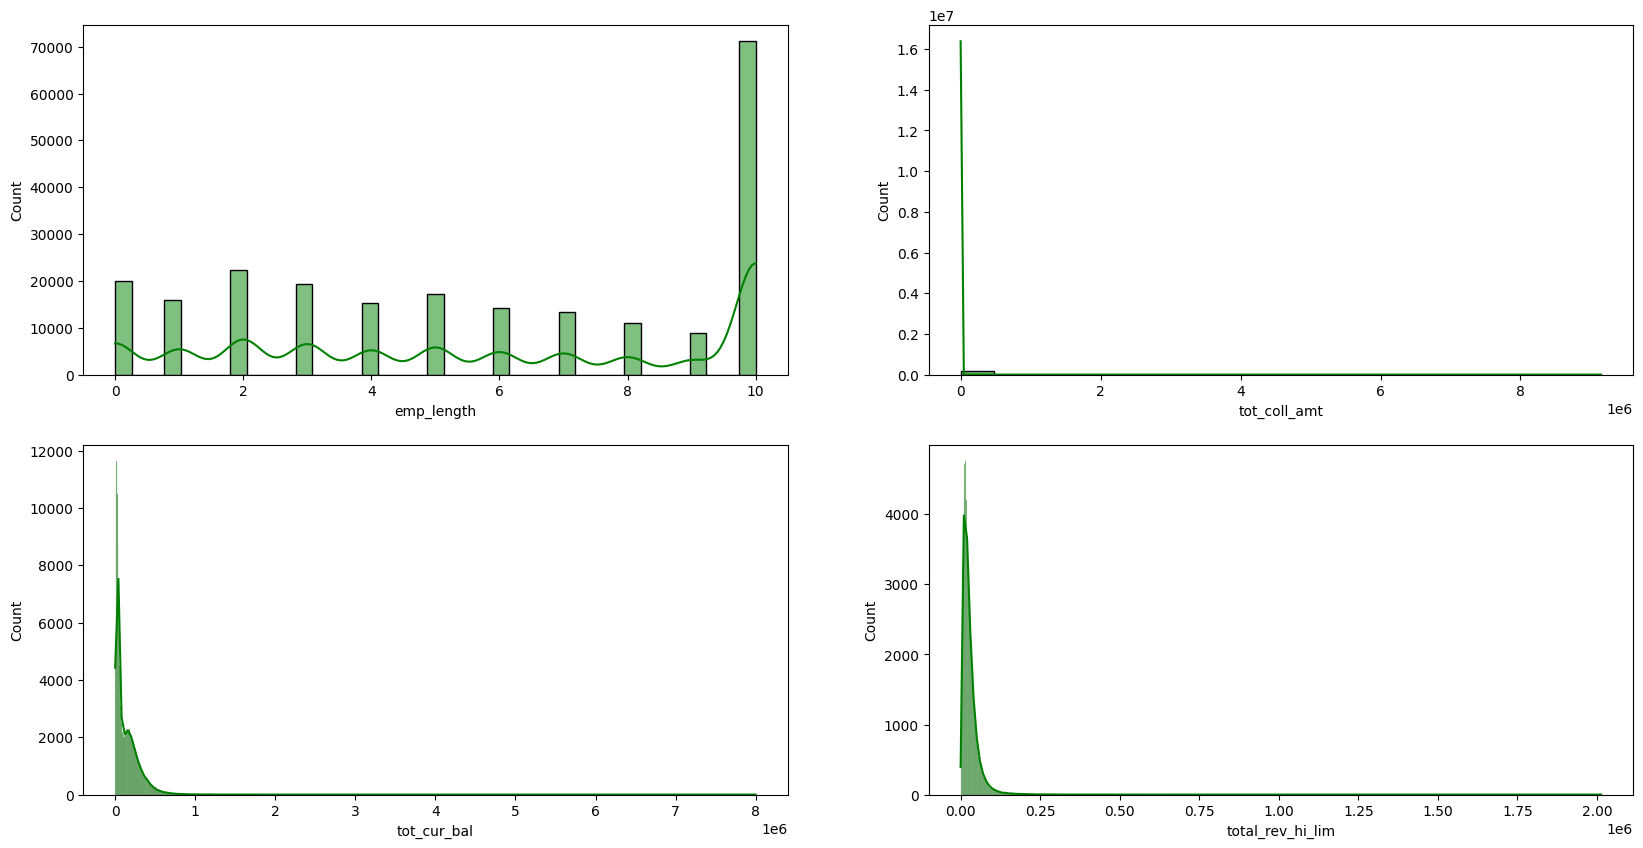

In [21]:
fig, axes = plt.subplots(2,2, figsize=(20,10))
sns.histplot(df['emp_length'],kde=True,ax=axes[0][0],color='green')
sns.histplot(df['tot_coll_amt'],kde=True,ax=axes[0][1],color='green')
sns.histplot(df['tot_cur_bal'],kde=True,ax=axes[1][0],color='green')
sns.histplot(df['total_rev_hi_lim'],kde=True,ax=axes[1][1],color='green')
plt.show()

From the distributions, the pictures show that all of them are skewed. Therefore, the median will be used to fill in the missing values.

In [22]:
x =['emp_length', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
for i in x:
    df[i] = df[i].fillna(df[i].median())

In [23]:
df = df.reset_index()
df.drop('index', axis=1, inplace=True)
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36,10.65,162.87,B,10.0,RENT,24000.0,Verified,Dec-11,0,n,credit_card,AZ,27.65,0.0,Jan-85,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.000,Jan-15,171.62,Jan-16,0.0,0.0,0.0,79293.0,22000.0
1,2500,2500,2500.0,60,15.27,59.83,C,0.0,RENT,30000.0,Source Verified,Dec-11,1,n,car,GA,1.00,0.0,Apr-99,5.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.110,Apr-13,119.66,Sep-13,0.0,0.0,0.0,79293.0,22000.0
2,2400,2400,2400.0,36,15.96,84.33,C,10.0,RENT,12252.0,Not Verified,Dec-11,0,n,small_business,IL,8.72,0.0,Nov-01,2.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.000,Jun-14,649.91,Jan-16,0.0,0.0,0.0,79293.0,22000.0
3,10000,10000,10000.0,36,13.49,339.31,C,10.0,RENT,49200.0,Source Verified,Dec-11,0,n,other,CA,20.00,0.0,Feb-96,1.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.000,Jan-15,357.48,Jan-15,0.0,0.0,0.0,79293.0,22000.0
4,5000,5000,5000.0,36,7.90,156.46,A,3.0,RENT,36000.0,Source Verified,Dec-11,0,n,wedding,AZ,11.20,0.0,Nov-04,3.0,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.000,Jan-15,161.03,Sep-15,0.0,0.0,0.0,79293.0,22000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238172,8525,8525,8525.0,60,18.25,217.65,D,5.0,MORTGAGE,37536.0,Verified,Jan-14,1,n,medical,MA,12.28,4.0,Nov-94,0.0,12.0,0.0,5318,10.7,26.0,f,0.0,0.0,2029.930000,2029.93,360.08,510.45,0.00,1159.40,11.594,May-14,217.65,Oct-14,0.0,0.0,0.0,116995.0,49800.0
238173,18000,18000,17975.0,36,7.90,563.23,A,3.0,RENT,90000.0,Verified,Jan-14,1,n,debt_consolidation,MD,10.33,1.0,Jul-98,0.0,16.0,0.0,8224,16.3,33.0,f,0.0,0.0,5631.670000,5623.85,4580.89,1050.78,0.00,0.00,0.000,Nov-14,563.23,Oct-14,0.0,0.0,0.0,42592.0,50300.0
238174,10000,10000,10000.0,36,18.25,362.78,D,10.0,RENT,42000.0,Source Verified,Jan-14,0,n,vacation,VA,11.57,0.0,Jun-02,0.0,9.0,0.0,3196,28.8,24.0,f,0.0,0.0,12394.165200,12394.17,10000.00,2394.17,0.00,0.00,0.000,Sep-15,5501.60,Jan-16,0.0,0.0,0.0,10170.0,11100.0
238175,22000,22000,22000.0,60,19.97,582.50,D,10.0,MORTGAGE,78000.0,Verified,Jan-14,1,n,debt_consolidation,TN,18.45,0.0,Jun-97,5.0,18.0,1.0,18238,46.3,30.0,f,0.0,0.0,4677.920000,4677.92,1837.04,2840.88,0.00,0.00,0.000,Dec-14,17.50,Jan-16,0.0,0.0,0.0,221830.0,39400.0


### Home Ownership

In [24]:
df['home_ownership'].value_counts()

MORTGAGE    117122
RENT        100795
OWN          20040
OTHER          177
NONE            42
ANY              1
Name: home_ownership, dtype: int64

Value `NONE` and `ANY` do not state a clear condition of home ownership. Those value will be changed into `OTHER`.

In [25]:
df['home_ownership'] = df['home_ownership'].replace('NONE', 'OTHER')
df['home_ownership'] = df['home_ownership'].replace('ANY', 'OTHER')

### Date Columns

Date columns will be transformed to show how many months it is until the present date.

#### issue_d

In [26]:
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df['issue_d_date'].head()

0   2011-12-01
1   2011-12-01
2   2011-12-01
3   2011-12-01
4   2011-12-01
Name: issue_d_date, dtype: datetime64[ns]

In [27]:
df['issue_d_date'].sort_values()

37622    2007-08-01
37621    2007-08-01
37611    2007-08-01
37613    2007-08-01
37614    2007-08-01
            ...    
164737   2014-12-01
164738   2014-12-01
164739   2014-12-01
164389   2014-12-01
165071   2014-12-01
Name: issue_d_date, Length: 238177, dtype: datetime64[ns]

This data range are from 2007 to 2014. Dec 2016 will be used as present time because in 2023, this data could be irrelevant.

In [28]:
df['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2016-12-01') - df['issue_d_date']) / np.timedelta64(1, 'M')))
df['mths_since_issue_d'].describe()

count    238177.000000
mean         45.579451
std          16.344529
min          24.000000
25%          33.000000
50%          42.000000
75%          53.000000
max         112.000000
Name: mths_since_issue_d, dtype: float64

In [29]:
df.drop(['issue_d', 'issue_d_date'], axis=1, inplace=True)

#### earliest_cr_line

This column will use the same method as `issue_d`.

In [30]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
df['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2016-12-01') - df['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
df['mths_since_earliest_cr_line'].describe()

count    238177.000000
mean        224.732640
std          89.873855
min        -624.000000
25%         171.000000
50%         211.000000
75%         267.000000
max         575.000000
Name: mths_since_earliest_cr_line, dtype: float64

Negative values have been found in this column. Further analysis will be performed.

In [31]:
df['earliest_cr_line_date'].sort_values(ascending=False).head()

19137    2068-12-01
234812   2068-12-01
174351   2068-12-01
151855   2068-12-01
132003   2068-12-01
Name: earliest_cr_line_date, dtype: datetime64[ns]

There is evidence that some year values are greater than 2016 (2016 used as present time). Therefore, 1200 will be summed into `mths_since_earliest_cr_line`. 1200 stands for 12 months times 100-year period, since 2068 should be 1968 (a 100-year difference), and so on.

In [32]:
true = []
for i in df['mths_since_earliest_cr_line']:
    if i < 0:
        true.append(i + 1200)
    else:
        true.append(i)
df['true_mths_since_earliest_cr_line'] = true
df['true_mths_since_earliest_cr_line'].sort_values().head()

164567    61.0
163996    62.0
165149    63.0
164478    63.0
169885    63.0
Name: true_mths_since_earliest_cr_line, dtype: float64

In [33]:
df.drop(['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line'], axis=1, inplace=True)

#### last_pymnt_d

This column will use the same method as `issue_d`.

In [34]:
df['last_pymnt_d_date'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%y')
df['mths_since_last_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2016-12-01') - df['last_pymnt_d_date']) / np.timedelta64(1, 'M')))
df['mths_since_last_pymnt_d'].describe()

count    238177.000000
mean         26.942560
std          14.040298
min          11.000000
25%          17.000000
50%          23.000000
75%          33.000000
max         108.000000
Name: mths_since_last_pymnt_d, dtype: float64

In [35]:
df.drop(['last_pymnt_d', 'last_pymnt_d_date'], axis=1, inplace=True)

#### last_credit_pull_d

This column will use the same method as `issue_d`.

In [36]:
df['last_credit_pull_d_date'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%y')
df['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2016-12-01') - df['last_credit_pull_d_date']) / np.timedelta64(1, 'M')))
df['mths_since_last_credit_pull_d'].describe()

count    238177.000000
mean         18.799964
std          12.171714
min          11.000000
25%          11.000000
50%          13.000000
75%          22.000000
max         112.000000
Name: mths_since_last_credit_pull_d, dtype: float64

In [37]:
df.drop(['last_credit_pull_d', 'last_credit_pull_d_date'], axis=1, inplace=True)

## Data Analysis

This analysis aiming for early warnings to identify bad borrowers based on borrower history.

### Based on Loan Purpose

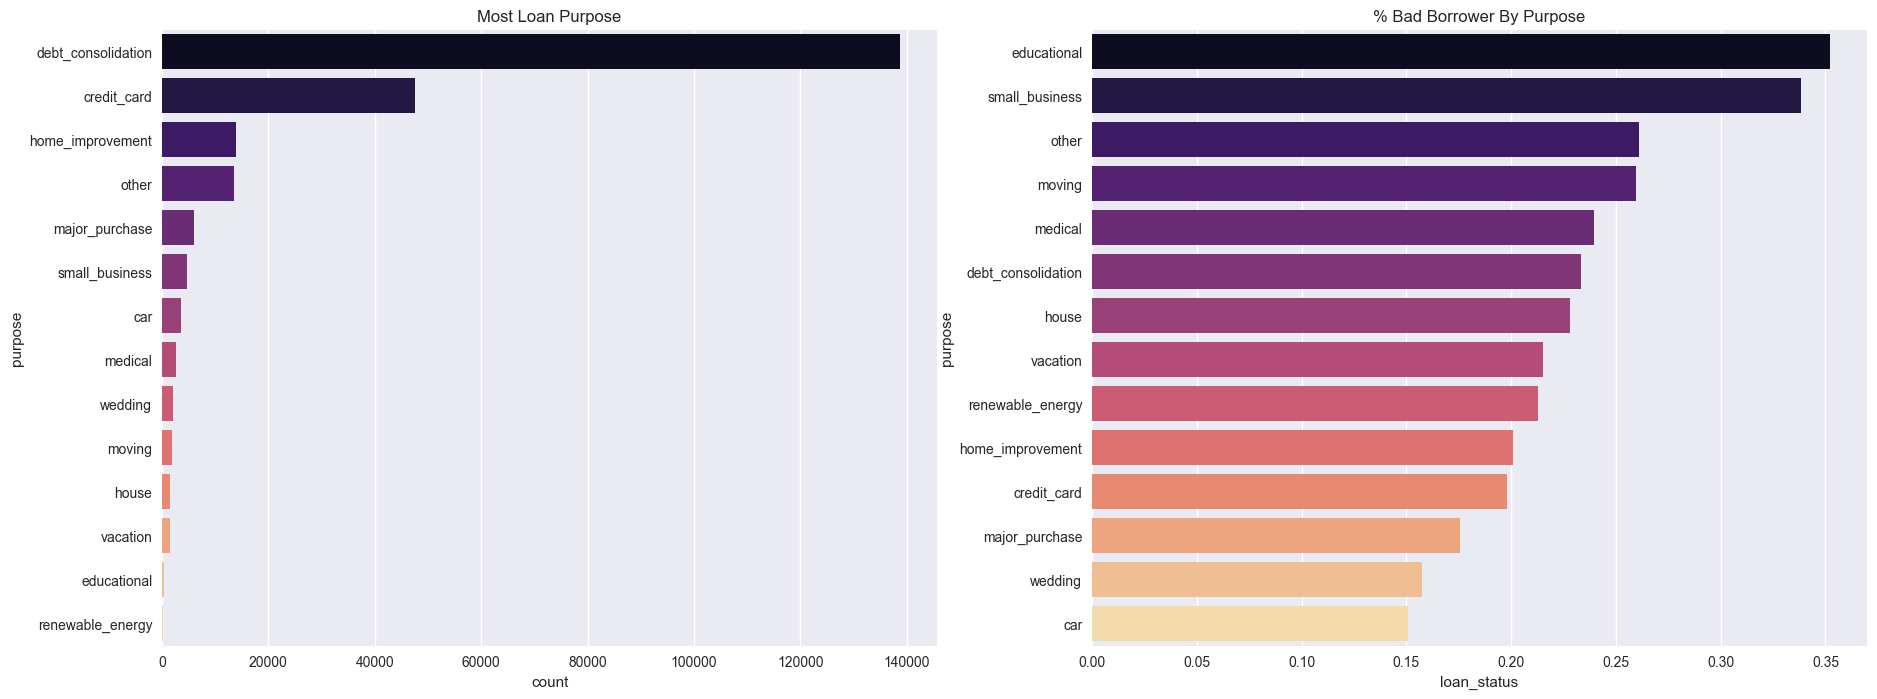

In [38]:
count_purp = df.groupby('purpose')['purpose'].agg(['count']).reset_index().sort_values( by='count', ascending=False)
badbor_purp = df.groupby("purpose",as_index=False)["loan_status"].mean().sort_values("loan_status",ascending=False)

plt.style.use('seaborn')
fig, axes = plt.subplots(1,2, figsize=(22,8))
sns.barplot(data=count_purp, x='count', y='purpose', ax=axes[0], palette="magma").set_title('Most Loan Purpose')
sns.barplot(data=badbor_purp, x="loan_status",y="purpose", ax=axes[1], palette="magma").set_title('% Bad Borrower By Purpose')
plt.show()

Most of borrower are using their loaned money to pay another debts, followed by credit card. But, car and wedding loan purposes have the highest chance to get the money back, while educational and small business purposes have the lowest chance to get the money back. It could be caused by the people who loan for educational and small business purposes are still trying to get money. And for the car and wedding purposes, they already have the money and financial planing to get the loan. 

Therefore, educational and small business purposes need more attention and further action when applying for the loaned money.

### Based on Term

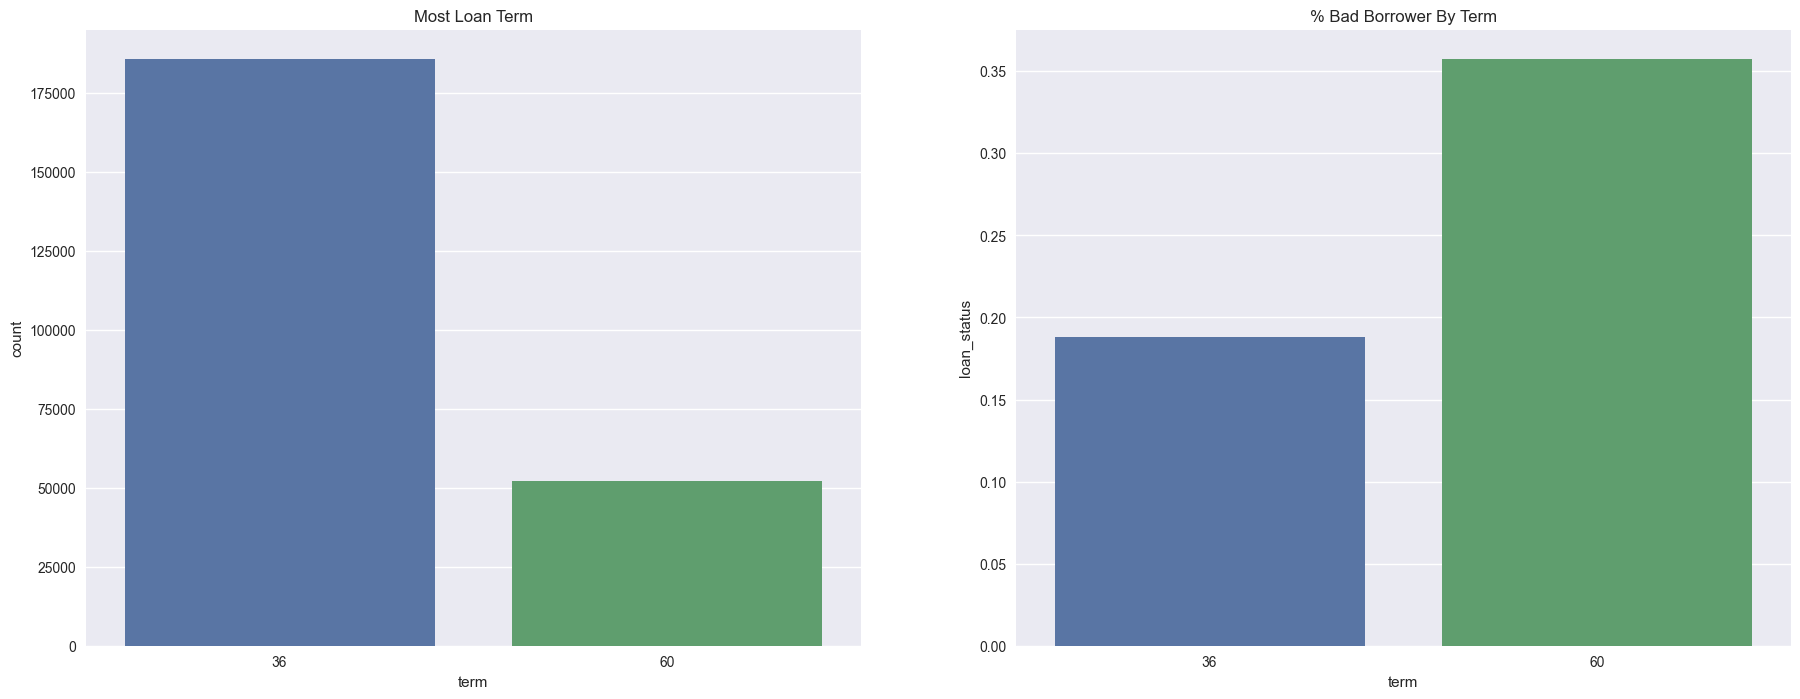

In [40]:
count_term = df.groupby('term')['term'].agg(['count']).reset_index()
badbor_term = df.groupby("term",as_index=False)["loan_status"].mean()

plt.style.use('seaborn')
fig, axes = plt.subplots(1,2, figsize=(22,8))
sns.barplot(data=count_term, x='term', y='count', ax=axes[0]).set_title('Most Loan Term')
sns.barplot(data=badbor_term, x='term', y='loan_status', ax=axes[1]).set_title('% Bad Borrower By Term')
plt.show()

In [41]:
count_term

,term,count
0,36,185860
1,60,52317


Most of borrowers are chosing 36-months installment. But, the 60-months installment borrowers have the higher risk to get the loaned money back. It could be caused by people who applied for 60-month installment are only have small amount of money to pay monthly bills while hoping the future getting better as time passed, such as income increase, to figure out and pay the whole bills.

Further action, analysis, and supervision are recommended for 60-months installment.

### Based on Borrower's Country

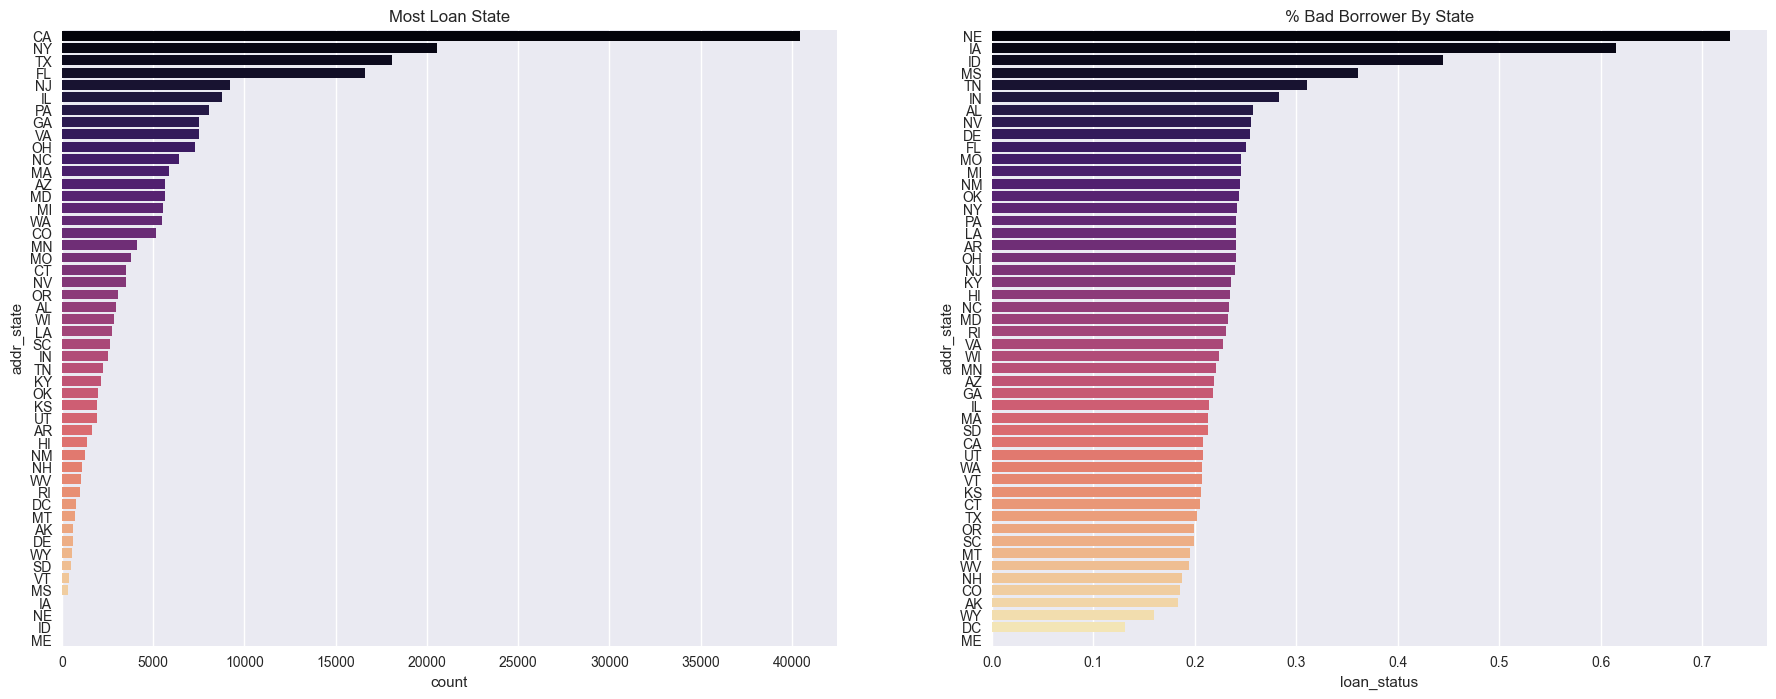

In [ ]:
count_state= df.groupby('addr_state')['addr_state'].agg(['count']).reset_index().sort_values( by='count', ascending=False)
badbor_state = df.groupby("addr_state",as_index=False)["loan_status"].mean().sort_values("loan_status",ascending=False)

plt.style.use('seaborn')
fig, axes = plt.subplots(1,2, figsize=(22,8))
sns.barplot(data=count_state, x='count', y='addr_state', ax=axes[0], palette="magma").set_title('Most Loan State')
sns.barplot(data=badbor_state, x="loan_status",y="addr_state", ax=axes[1], palette="magma").set_title('% Bad Borrower By State')
plt.show()

The majority of borrowers are from CA (California), followed by NY (New York), TX (Texas), and FL(Florida). But, NE (Nebraska), IA (Iowa), ID (Idaho), MS (Mississippi), and TN (Tennessee) are the highest risk of getting the loaned money back (above 30% borrowers). Further action, borrowers analysis, and supervision are recommended for borrowers from Nebraska, Iowa, Idaho, Mississippi, and Tennessee.

### Based on Grade

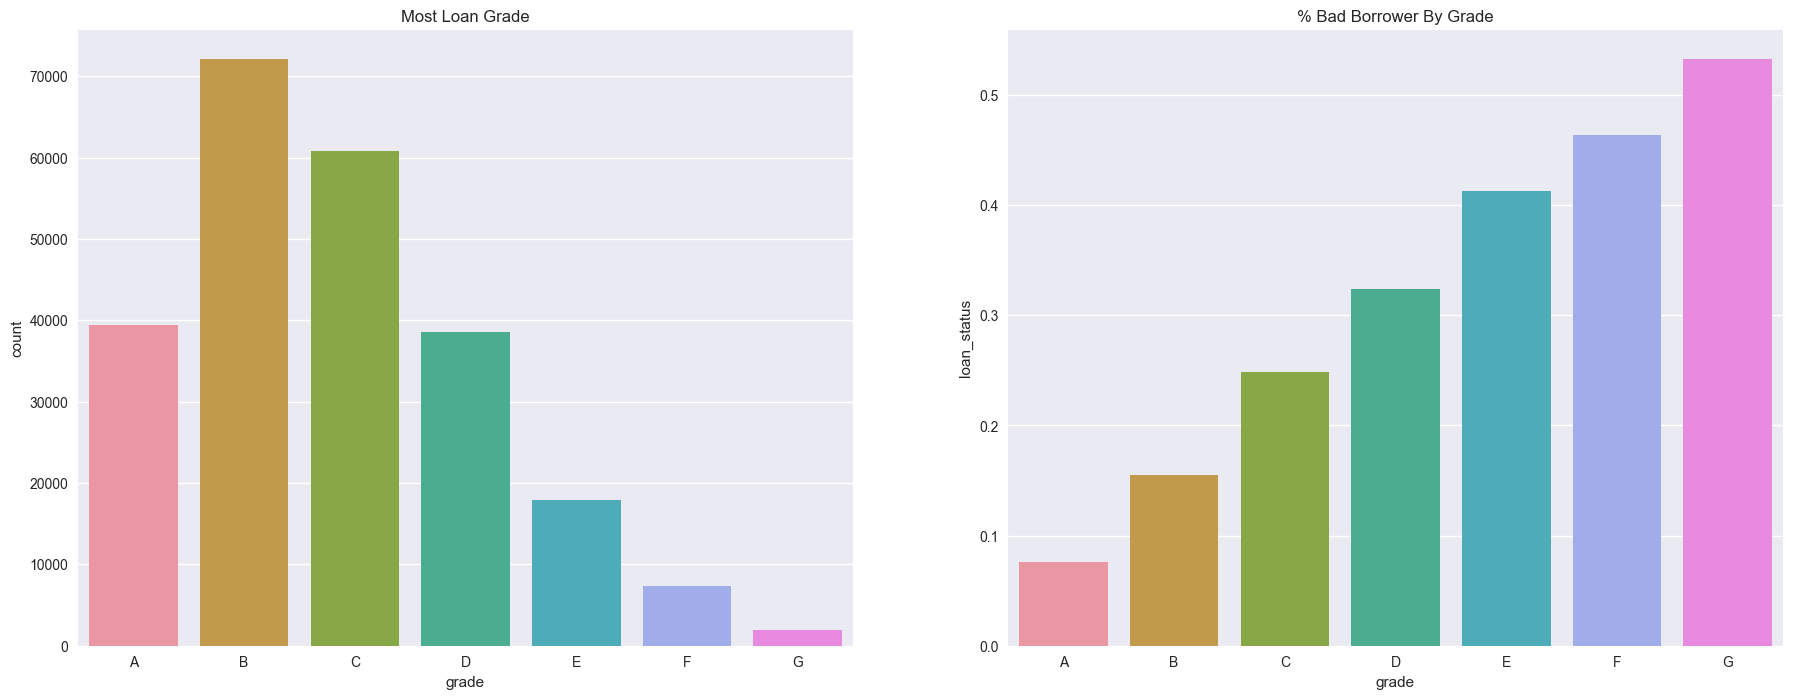

In [ ]:
count_grade = df.groupby('grade')['grade'].agg(['count']).reset_index()
badbor_grade = df.groupby("grade",as_index=False)["loan_status"].mean()

plt.style.use('seaborn')
fig, axes = plt.subplots(1,2, figsize = (22,8))
sns.barplot(data=count_grade, x='grade', y='count',ax=axes[0]).set_title('Most Loan Grade')
sns.barplot(data=badbor_grade, x='grade', y='loan_status', ax=axes[1]).set_title('% Bad Borrower By Grade')
plt.show()

The majority of borrowers are rated B, followed by C. And from the right graph, the grade G borrowers have the highest risk of getting the loaned money back. The lower the grade (A = highest, G = lowest), the more action and borrower analysis are required.

### Based on Home Ownership

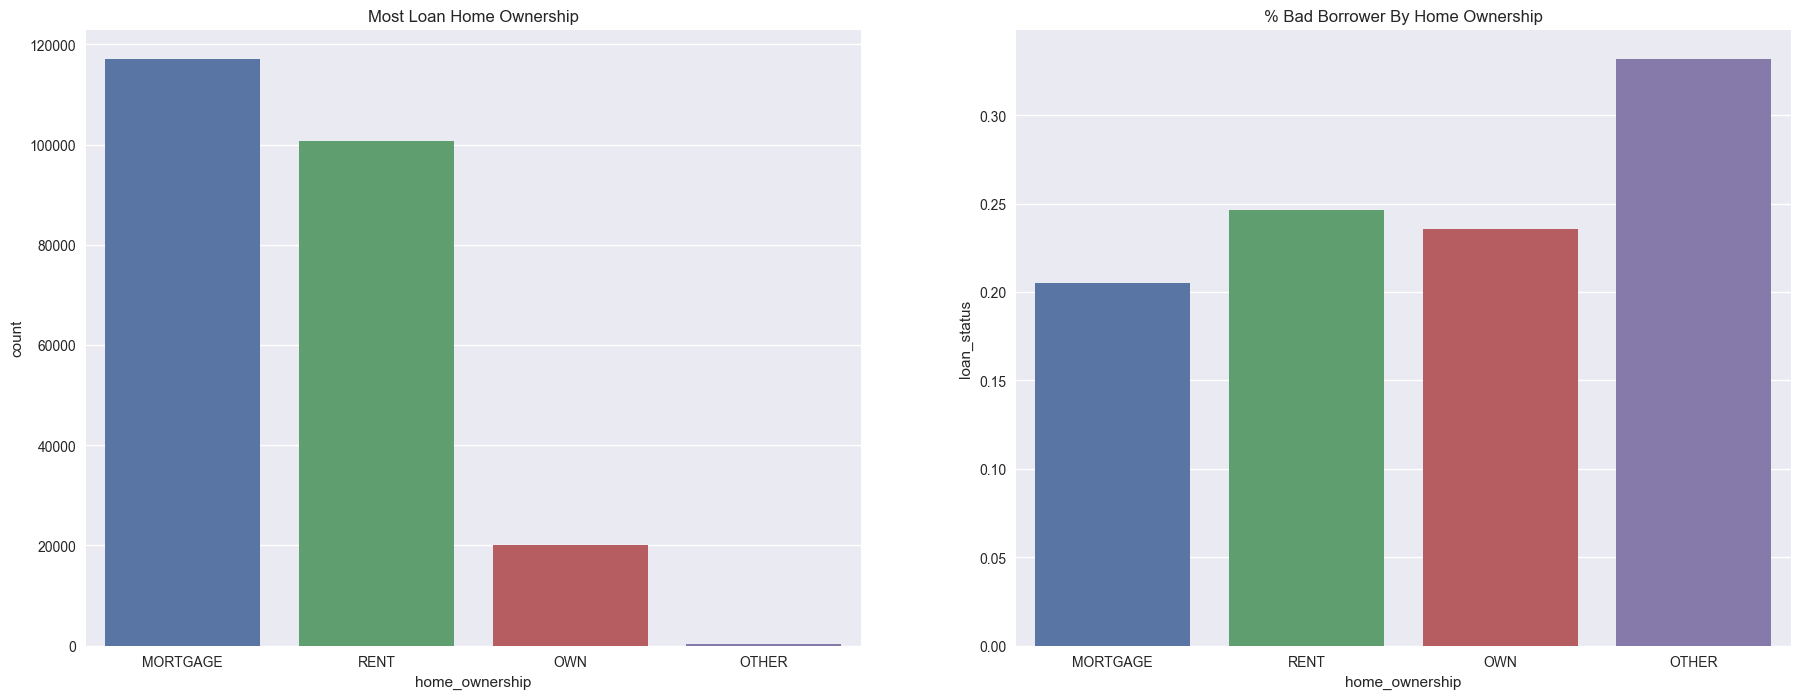

In [ ]:
count_home = df.groupby('home_ownership')['home_ownership'].agg(['count']).reset_index().sort_values(by='count', ascending=False)
badbor_home = df.groupby("home_ownership",as_index=False)["loan_status"].mean()

plt.style.use('seaborn')
fig, axes = plt.subplots(1,2, figsize = (22,8))
sns.barplot(data=count_home, x='home_ownership', y='count',ax=axes[0]).set_title('Most Loan Home Ownership')
sns.barplot(data=badbor_home, x='home_ownership', y='loan_status', ax=axes[1], order=["MORTGAGE","RENT","OWN","OTHER"]).set_title('% Bad Borrower By Home Ownership')
plt.show()

The most borrowers are having a mortgage house, followed by rent and own. In the other side, mortgage are also the lowest risk to get the loaned money back, followed by own and rent. This could be caused by people with mortgage are already have a good financial planning how to pay the bills or in this case, the loaned money. 

Therefore, further action, analysis and supervision are recommended for other home ownership are recommended when applying for the loaned money.

## Data Preparation

### Feature Selection

#### Information Value

In [ ]:
#categoric fitur dan continuous fiture

class CategoricalFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature

    @property
    def df_lite(self):
        df_lite = self.df
        df_lite['bin'] = df_lite[self.feature].fillna('MISSING')
        return df_lite[['bin', 'loan_status']]


class ContinuousFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature
        self.bin_min_size = int(len(self.df) * 0.05)

    def __generate_bins(self, bins_num):
        df = self.df[[self.feature, 'loan_status']]
        df['bin'] = pd.qcut(df[self.feature], bins_num, duplicates='drop') \
                    .apply(lambda x: x.left) \
                    .astype(float)
        return df

    def __generate_correct_bins(self, bins_max=20):
        for bins_num in range(bins_max, 1, -1):
            df = self.__generate_bins(bins_num)
            df_grouped = pd.DataFrame(df.groupby('bin') \
                                      .agg({self.feature: 'count',
                                            'loan_status': 'sum'})) \
                                      .reset_index()
            r, p = stats.stats.spearmanr(df_grouped['bin'], df_grouped['loan_status'])

            if (
                    abs(r)==1 and                                                        # periksa apakah WOE untuk tiap bin adalah monotomic
                    df_grouped[self.feature].min() > self.bin_min_size                   # periksa apakah size setiap bin besar dari 5%
                    and not (df_grouped[self.feature] == df_grouped['loan_status']).any()      # periksa apakah label Yes dan No jumlahnya adalah 0
            ):
                break

        return df

    @property
    def df_lite(self):
        df_lite = self.__generate_correct_bins()
        df_lite['bin'].fillna('MISSING', inplace=True)
        return df_lite[['bin', 'loan_status']]

In [ ]:
# Information Value
pd.set_option('mode.chained_assignment', None)

class AttributeRelevance():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def bulk_iv(self, feats, iv, woe_extremes=False):
        iv_dict = {}
        for f in feats:
            iv_df, iv_value = iv.calculate_iv(f)
            if woe_extremes:
                iv_dict[f.feature] = [iv_value, iv_df['woe'].min(), iv_df['woe'].max()]
                cols = ['iv', 'woe_min', 'woe_max']
            else:
                iv_dict[f.feature] = iv_value
                cols = ['iv']
        df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=cols)
        return df

    def bulk_stats(self, feats, s):
        stats_dict = {}
        for f in feats:
            p_value, effect_size = s.calculate_chi(f)
            stats_dict[f.feature] = [p_value, effect_size]
        df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['p-value', 'effect_size'])
        return df

    def analyze(self, feats, iv, s=None, interpretation=False):
        df_iv = self.bulk_iv(feats, iv).sort_values(by='iv', ascending=False)
        if s is not None:
            df_stats = self.bulk_stats(feats, s)
            df_iv = df_iv.merge(df_stats, left_index=True, right_index=True)
        if interpretation:
            df_iv['iv_interpretation'] = df_iv['iv'].apply(iv.interpretation)
            if s is not None:
                df_iv['es_interpretation'] = df_iv['effect_size'].apply(s.interpretation)
        return df_iv

    def draw_iv(self, feats, iv):
        df = self.analyze(feats, iv)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=df.index, y='iv', data=df, palette=self.seq_palette(len(feats)))
        ax.set_title('IV values')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_extremes(self, feats, iv):
        df = self.bulk_iv(feats, iv, woe_extremes=True).sort_values(by='iv', ascending=False)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=df.index, y='woe_min', data=df, palette=self.seq_palette(len(feats)))
        sns.barplot(x=df.index, y='woe_max', data=df, palette=self.seq_palette(len(feats)))
        ax.axhline(y=0, color='black', linewidth=1)
        ax.set_title('Range of WOE values')
        ax.set_ylabel('WOE')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_multiplot(self, feats, iv):
        n = len(feats)
        nrows = int(np.ceil(n/3))
        fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*4))
        for i in range(n):
            iv_df, iv_value = iv.calculate_iv(feats[i])
            sns.barplot(x=feats[i].feature, y='woe', data=iv_df, color='#455872', ax=fig.axes[i])

        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=50)

        plt.tight_layout()
        plt.show()

class Analysis():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def group_by_feature(self, feat):
        df = feat.df_lite \
                            .groupby('bin') \
                            .agg({'loan_status': ['count', 'sum']}) \
                            .reset_index()
        df.columns = [feat.feature, 'count', 'good']
        df['bad'] = df['count'] - df['good']
        return df

class StatsSignificance(Analysis):
    def calculate_chi(self, feat):
        df = self.group_by_feature(feat)
        df_chi = np.array(df[['good', 'bad']])
        n = df['count'].sum()

        chi = stats.chi2_contingency(df_chi)
        cramers_v = np.sqrt(chi[0] / n)          # assume that k=2 (good, bad)
        return chi[1], cramers_v

    @staticmethod
    def interpretation(cramers_v):
        if cramers_v < 0.1:
            return 'useless'
        elif cramers_v < 0.2:
            return 'weak'
        elif cramers_v < 0.4:
            return 'medium'
        elif cramers_v < 0.6:
            return 'strong'
        else:
            return 'very strong'

    def interpret_chi(self, feat):
        _, cramers_v = self.calculate_chi(feat)
        return self.interpretation(cramers_v)

    def print_chi(self, feat):
        p_value, cramers_v = self.calculate_chi(feat)
        print('P-value: %0.2f\nEffect size: %0.2f' % (p_value, cramers_v))
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(cramers_v)))


class IV(Analysis):
    @staticmethod
    def __perc_share(df, group_name):
        return df[group_name] / df[group_name].sum()

    def __calculate_perc_share(self, feat):
        df = self.group_by_feature(feat)
        df['perc_good'] = self.__perc_share(df, 'good')
        df['perc_bad'] = self.__perc_share(df, 'bad')
        df['perc_diff'] = df['perc_good'] - df['perc_bad']
        return df

    def __calculate_woe(self, feat):
        df = self.__calculate_perc_share(feat)
        df['woe'] = np.log(df['perc_good']/df['perc_bad'])
        df['woe'] = df['woe'].replace([np.inf, -np.inf], np.nan).fillna(0)
        return df

    def calculate_iv(self, feat):
        df = self.__calculate_woe(feat)
        df['iv'] = df['perc_diff'] * df['woe']
        return df, df['iv'].sum()

    def draw_woe(self, feat):
        iv_df, iv_value = self.calculate_iv(feat)
        fig, ax = plt.subplots(figsize=(10,6))
        sns.barplot(x=feat.feature, y='woe', data=iv_df, palette=self.seq_palette(len(iv_df.index)))
        ax.set_title('WOE visualization for: ' + feat.feature)
        plt.show()
        plt.show()

    @staticmethod
    def interpretation(iv):
        if iv < 0.02:
            return 'useless'
        elif iv < 0.1:
            return 'weak'
        elif iv < 0.3:
            return 'medium'
        elif iv < 0.5:
            return 'strong'
        else:
            return 'suspicious'

    def interpret_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        return self.interpretation(iv)

    def print_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        print('Information value: %0.2f' % iv)
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(iv)))

In [ ]:
#selection feat
feats_dict = {}

for col in [c for c in df.columns if c != 'loan_status']:
  if is_numeric_dtype(df[col]):
    feats_dict[col] = ContinuousFeature(df,col)
  else :
    feats_dict[col] = CategoricalFeature(df,col)

feats = list(feats_dict.values())

In [ ]:
iv = IV()
s = StatsSignificance()

ar = AttributeRelevance()


df_analysis = ar.analyze(feats, iv, s, interpretation=True)
display(df_analysis)

,iv,p-value,effect_size,iv_interpretation,es_interpretation
last_pymnt_amnt,3.303047,0.000000e+00,0.535086,suspicious,strong
total_rec_prncp,2.618195,0.000000e+00,0.628138,suspicious,very strong
total_pymnt_inv,1.228500,0.000000e+00,0.445867,suspicious,strong
total_pymnt,1.215934,0.000000e+00,0.445439,suspicious,strong
grade,0.420736,0.000000e+00,0.262734,strong,medium
int_rate,0.386954,0.000000e+00,0.248267,strong,medium
dti,0.084445,0.000000e+00,0.123238,weak,weak
revol_util,0.056680,0.000000e+00,0.096582,weak,useless
annual_inc,0.044740,0.000000e+00,0.087937,weak,useless
mths_since_issue_d,0.038970,0.000000e+00,0.082800,weak,useless


In [ ]:
# Drop columns with 'suspicious' IV
df.drop(['last_pymnt_amnt', 'total_rec_prncp', 'total_pymnt', 'total_pymnt_inv'], axis=1, inplace=True)
# Drop columns made from determine IV process
df.drop(['bin'], axis=1, inplace=True)

#### Correlation

Text(0.5, 1.0, 'Correlation Matrix')

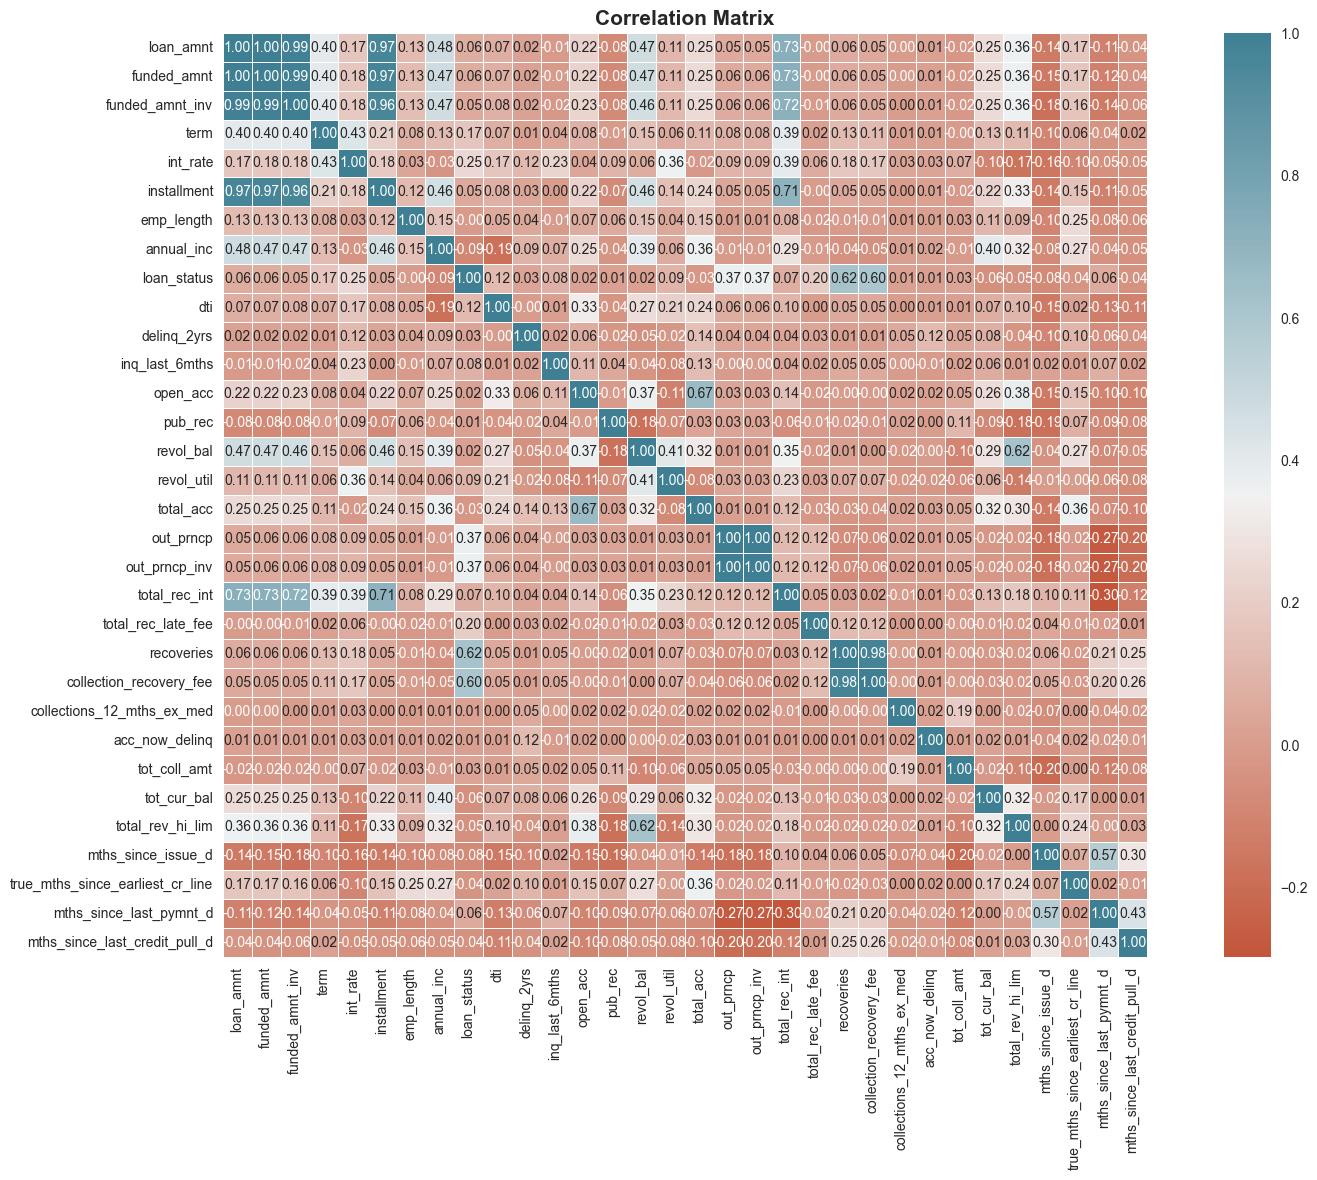

In [ ]:
plt.figure(figsize=(20, 12))
palette=sns.diverging_palette(20, 220, n=256)
corr = df.corr(method='spearman')
sns.heatmap(corr, annot=True, fmt='.2f', cmap=palette, square=True, linewidths=.5)
plt.title('Correlation Matrix', size=15, weight='bold')

Features with correlation above 0.8 will ber removed

In [ ]:
df.drop(['funded_amnt', 'funded_amnt_inv', 'installment', 'out_prncp_inv', 'collection_recovery_fee'], axis=1, inplace=True)

#### Categorical Columns

From the categorical columns, we try to find is there any columns with dominant value over another.

In [ ]:
for col in df.select_dtypes(include='object').columns.tolist():
    print(df[col].value_counts(normalize=True)*100)
    print('\n')

B    30.278742
C    25.557464
A    16.553236
D    16.181243
E     7.540191
F     3.065367
G     0.823757
Name: grade, dtype: float64


MORTGAGE    49.174354
RENT        42.319368
OWN          8.413911
OTHER        0.092368
Name: home_ownership, dtype: float64


Verified           37.208043
Not Verified       34.705282
Source Verified    28.086675
Name: verification_status, dtype: float64


n    99.997061
y     0.002939
Name: pymnt_plan, dtype: float64


debt_consolidation    58.266751
credit_card           19.967923
home_improvement       5.808705
other                  5.701222
major_purchase         2.494783
small_business         2.001873
car                    1.463198
medical                1.130252
wedding                0.840551
moving                 0.793108
house                  0.642379
vacation               0.612150
educational            0.170461
renewable_energy       0.106643
Name: purpose, dtype: float64


CA    16.978550
NY     8.620060
TX     7.601490
FL     6.96498

Column `pymnt_plan` has more than 99% of 'n' value. This column will be deleted.

In [ ]:
df.drop(['pymnt_plan'], axis=1, inplace=True)

### Spliting Data

In [ ]:
x = df.drop(columns=['loan_status'])
y = df['loan_status']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

### Encoding

In [ ]:
ordinal_mapping = [
    {'col':'grade',
    'mapping':{'G' : 0,
    'F' : 1,
    'E' : 2,
    'D' : 3,
    'C' : 4,
    'B' : 5,
    'A' : 6
    }}]

In [ ]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['verification_status', 'initial_list_status']),
    ('ordinal', ce.OrdinalEncoder(mapping= ordinal_mapping), ['grade']),
    ('binary', ce.BinaryEncoder(), ['addr_state','purpose', 'home_ownership']),
    ('robust', RobustScaler(), df.select_dtypes(exclude='O').drop('loan_status', axis=1).columns.tolist())
], remainder='passthrough')

In [ ]:
rs = RobustScaler()
std = pd.DataFrame(rs.fit_transform(df[df.select_dtypes(exclude='O').drop('loan_status', axis=1).columns.tolist()]), columns=df.select_dtypes(exclude='O').drop('loan_status', axis=1).columns.tolist())

In [ ]:
std.head()

,loan_amnt,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_rec_int,total_rec_late_fee,recoveries,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_issue_d,true_mths_since_earliest_cr_line,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
0,-0.648148,0.0,-0.539286,0.571429,-0.914634,1.030466,0.0,0.0,-1.166667,0.0,0.200943,0.725806,-0.8750,0.0,-0.311295,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.9,1.773196,0.0000,-0.181818
1,-0.879630,24.0,0.285714,-0.857143,-0.768293,-1.357527,0.0,4.0,-1.166667,0.0,-0.708432,-1.271505,-1.1875,0.0,-0.528516,0.00,117.08,0.0,0.0,0.0,0.0,0.0,0.9,0.010309,1.3125,2.363636
2,-0.888889,0.0,0.408929,0.571429,-1.201171,-0.665771,0.0,1.0,-1.333333,0.0,-0.611952,1.123656,-0.8125,0.0,-0.442586,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.9,-0.309278,0.4375,-0.181818
3,-0.185185,0.0,-0.032143,0.571429,-0.300000,0.344982,0.0,0.0,0.000000,0.0,-0.411085,-0.959677,0.8750,0.0,0.376354,16.97,0.00,0.0,0.0,0.0,0.0,0.0,0.9,0.402062,0.0000,0.909091
4,-0.648148,0.0,-1.030357,-0.428571,-0.621951,-0.443548,0.0,2.0,-0.166667,0.0,-0.231278,-0.763441,-0.6875,0.0,-0.428443,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.9,-0.680412,0.0000,0.181818


## Modeling

In [ ]:
rf = RandomForestClassifier(random_state=28)
xgb = XGBClassifier(random_state=28)
lgbm = lgb.LGBMClassifier(random_state=28)
lr = LogisticRegression(random_state=28)

### Benchmark model: Data Train

In [ ]:
models = [rf, xgb, lgbm, lr]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Random Forest', 'XGBoost', 'LightGBM', 'Logistic Regression'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

,mean roc_auc,sdev
model,,
LightGBM,0.970499,0.001380
XGBoost,0.970172,0.001279
Random Forest,0.962082,0.001853
Logistic Regression,0.914199,0.002480


### Benchmark model: Data Test

In [ ]:
models = [lr,rf,xgb,lgbm]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression','Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,x_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
before_tuning = pd.DataFrame({'model':['Logistic Regression', 'Random Forest', 'XGBoost','LightGBM'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)
before_tuning

Logistic Regression 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95     36909
           1       0.97      0.64      0.77     10727

    accuracy                           0.92     47636
   macro avg       0.94      0.82      0.86     47636
weighted avg       0.92      0.92      0.91     47636

Random Forest 
               precision    recall  f1-score   support

           0       0.92      0.99      0.96     36909
           1       0.97      0.71      0.82     10727

    accuracy                           0.93     47636
   macro avg       0.94      0.85      0.89     47636
weighted avg       0.93      0.93      0.93     47636

XGBoost 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     36909
           1       0.92      0.77      0.84     10727

    accuracy                           0.93     47636
   macro avg       0.93      0.88      0.90     47636
weighted avg       0.93   

,roc_auc score
model,
LightGBM,0.969962
XGBoost,0.969669
Random Forest,0.961056
Logistic Regression,0.914897


### Hyperparameter Tuning

Only the top two models will be used in future action, XGBoost and LightGBM.

In [ ]:
xgb = XGBClassifier(random_state=28)
lgbm = lgb.LGBMClassifier(random_state=28)
pipe_xgb=Pipeline([('preprocess',transformer), ('model_xgb',xgb)])
pipe_lgbm=Pipeline([('preprocess',transformer), ('model_lgbm',lgbm)])
crossval = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)

In [ ]:
# XGBoost Hyperparameter Tuning
hyperparam_xgb = [{
              'model_xgb__n_estimators':[100,200,300],
              'model_xgb__max_depth':[7,9,11],
              'model_xgb__learning_rate':[0.1, 0.01, 0.3]}]

xgb_grid = GridSearchCV(estimator = pipe_xgb,
                      param_grid = hyperparam_xgb, 
                      cv = crossval, 
                      scoring = 'roc_auc',
                      error_score='raise',
                      n_jobs = -1)
xgb_grid.fit(x_train,y_train)

In [ ]:
print('XGBoost Hyperparameter')
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

XGBoost Hyperparameter
0.9711149154050436
{'model_xgb__learning_rate': 0.1, 'model_xgb__max_depth': 9, 'model_xgb__n_estimators': 200}


In [ ]:
# LightGBM Hyperparameter Tuning
hyperparam_lgbm = [{
            'model_lgbm__max_bin': [250,275,300],
            'model_lgbm__num_leaves':[31,41,51],
            'model_lgbm__min_data_in_leaf': [15,20,30],
            'model_lgbm__num_iterations':[75,100,150],
            'model_lgbm__learning_rate': [0.1,0.075,0.125]}]

lgbm_grid = GridSearchCV(estimator = pipe_lgbm,
                      param_grid = hyperparam_lgbm, 
                      cv = crossval, 
                      scoring = 'roc_auc',
                      error_score='raise',
                      n_jobs = -1)
lgbm_grid.fit(x_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=28, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['verification_status',
                                                                          'initial_list_status']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'grade',
                                                                                                  'mapping': {'A': 6,
                                                                                                              'B': 5,
                                                                                                              'C'...
                                                                          'mths_since_last_pymnt_d',
                                                                          'mths_since_last_credit_pull_d'])])),
                                       ('model_lgbm',
                                        LGBMClassifier(random_state=28))]),
             n_jobs=-1,
             param_grid=[{'model_lgbm__learning_rate': [0.1, 0.075, 0.125],
                          'model_lgbm__max_bin': [250, 275, 300],
                          'model_lgbm__min_data_in_leaf': [15, 20, 30],
                          'model_lgbm__num_iterations': [75, 100, 150],
                          'model_lgbm__num_leaves': [31, 41, 51]}],
             scoring='roc_auc')

In [ ]:
print('LightGBM Hyperparameter')
print(lgbm_grid.best_score_)
print(lgbm_grid.best_params_)

LightGBM Hyperparameter
0.9711282526234968
{'model_lgbm__learning_rate': 0.1, 'model_lgbm__max_bin': 275, 'model_lgbm__min_data_in_leaf': 30, 'model_lgbm__num_iterations': 150, 'model_lgbm__num_leaves': 41}


In [ ]:
after_tuning = pd.DataFrame({'model':['LightGBM After Tuning','XGBoost After Tuning'], 'roc_auc score':[lgbm_grid.best_score_, xgb_grid.best_score_]}).set_index('model').sort_values(by='roc_auc score', ascending=False)
after_tuning

,roc_auc score
model,
LightGBM After Tuning,0.971128
XGBoost After Tuning,0.971115


## Final Model

In [ ]:
best_model = lgbm_grid.best_estimator_
predict = best_model.fit(x_train, y_train)
pickle.dump(predict, open('Loan Risk Analysis.sav', 'wb'))

There are few things to do before using this model:
- Turning date columns into total months until present date.
- Make sure there is only 4 values in column `home_ownership`: MORTGAGE, RENT, OWN, and OTHER.
- Check that the data is complete, with no missing values and no high dominant values.
- Make sure there is no information leakage and no multicolinearity

## Conclusion

In [ ]:
display(before_tuning.head(1), after_tuning.head(1), lgbm_grid.best_params_)


,roc_auc score
model,
LightGBM,0.969962


,roc_auc score
model,
LightGBM After Tuning,0.971128


{'model_lgbm__learning_rate': 0.1,
 'model_lgbm__max_bin': 275,
 'model_lgbm__min_data_in_leaf': 30,
 'model_lgbm__num_iterations': 150,
 'model_lgbm__num_leaves': 41}

The LightGBM model after hyperparameter tuning is the best model, with a ROC AUC performance of `0.971128`. This means this model can correctly classify more than 97% of the data.<br>
The parameters used are:
1. learning_rate: 0.1 
2. max_bin: 275
3. min_data_in_leaf: 30
4. num_iterations: 150
5. num_leaves: 41

Beside that, there are a few things that could be used to perform `early steps to identify bad borrowers,` including the following:
1. Educational and small business purposes need more attention and further action when applying for the loaned money.
2. Further action, borrower analysis, and supervision are recommended for 60-months installment.
3. Further action, borrower analysis, and supervision are recommended for borrowers from Nebraska, Iowa, Idaho, Mississippi, and Tennessee.
4. Further action, borrower analysis, and supervision are recommended for 'other' category in home ownership are recommended when applying for the loaned money.
5. The lower the grade, the more action and borrower analysis are required.